# Desafio Lighthouse Ciência de Dados

## Desafio

Você foi alocado(a) em um time da Indicium que está trabalhando atualmente junto a um cliente no processo de criação de uma plataforma de aluguéis temporários na cidade de Nova York. Para o desenvolvimento de sua estratégia de precificação, pediu para que a Indicium fizesse uma análise exploratória dos dados de seu maior concorrente, assim como um teste de validação de um modelo preditivo.

Seu objetivo é desenvolver um modelo de previsão de preços a partir do dataset oferecido, e avaliar tal modelo utilizando as métricas de avaliação que mais fazem sentido para o problema. O uso de outras fontes de dados além do dataset é permitido (e encorajado). Você poderá encontrar em anexo um dicionário dos dados.

---
Entregas

1. Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses de negócio relacionadas. Seja criativo!
2. Responda também às seguintes perguntas:
  - Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?
 - O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?
 - Existe algum padrão no texto do nome do local para lugares de mais alto valor?
3. Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?
4. Supondo um apartamento com as seguintes características:

{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

Qual seria a sua sugestão de preço?
5. Salve o modelo desenvolvido no formato .pkl.
6. A entrega deve ser feita através de um repositório de código público que contenha:
 - README explicando como instalar e executar o projeto
 - Arquivo de requisitos com todos os pacotes utilizados e suas versões
 - Relatórios das análises estatísticas e EDA em PDF, Jupyter Notebook ou semelhante conforme passo 1 e 2.
 - Códigos de modelagem utilizados no passo 3 (pode ser entregue no mesmo Jupyter Notebook).
 - Arquivo .pkl conforme passo 5 acima.
7. Um vídeo curto explicando o desenvolvimento de suas entregas deste desafio, como você planejou e executou as atividades propostas. O vídeo deverá ser entregue via link via Google Drive. Lembre-se de autorizar o acesso para "qualquer pessoa com o link".

Todos os códigos produzidos devem seguir as boas práticas de codificação.


## Preparação do Ambiente e Carregamento dos dados

In [1]:
#imports necessários
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.feature_extraction.text import CountVectorizer
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import joblib


In [2]:
# Carregamento dos dados

df = pd.read_csv("../data/teste_indicium_precificacao.csv")

## Contextualização dos Dados

In [3]:
# Informa quantas linhas e quantas colunas existem no nosso dataset
df.shape

(48894, 16)

In [4]:
# Mostra as primeiras linhas do dataset
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [5]:
df.dtypes

id                                 int64
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object

Ao analisar o dataset dado, é possível observar que existem 48894 amostras, com informações dividas entre 16 variáveis, sendo elas:
- **Categóricas**
  - id
  - nome
  - host_id
  - host_name
  - bairro_group
  - bairro
  - room_type
  
- **Numéricas**
  - latitude
  - longitude
  - price
  - minimo_noites
  - numero_de_reviews
  - reviews_por_mes
  - calculado_host_listings_count
  - disponibilidade_365

- **Temporal**
 - ultima_review

## Setando os tipos corretos nos campos

Algumas colunas não estão setadas para o tipo de variável correta, então irei corrigir para facilitar análises futuras.

In [6]:
# Ajusta os tipos dos dados categoricos
df['id'] = df['id'].astype('category')
df['nome'] = df['nome'].astype('category')
df['host_id'] = df['host_id'].astype('category')
df['host_name'] = df['host_name'].astype('category')
df['bairro_group'] = df['bairro_group'].astype('category')
df['bairro'] = df['bairro'].astype('category')
df['room_type'] = df['room_type'].astype('category')

# Ajusta o tipo dos dados temporais
df['ultima_review'] = pd.to_datetime(df['ultima_review'])

# Ajusta os tipos dos dados numéricos
df['minimo_noites'] = df['minimo_noites'].astype('int32')
df['numero_de_reviews'] = df['numero_de_reviews'].astype('int32')
df['calculado_host_listings_count'] = df['calculado_host_listings_count'].astype('int32')
df['disponibilidade_365'] = df['disponibilidade_365'].astype('int32')


In [7]:
# Mostra quais são os diferentes valores na coluna de room_type
df['room_type'].cat.categories

Index(['Entire home/apt', 'Private room', 'Shared room'], dtype='object')

In [8]:
# Mostra quais são os bairros que existem nos anúncios
df['bairro_group'].cat.categories

Index(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'], dtype='object')

## Detecção e remoção de outliers

In [9]:
numerical_features = ['price', 'minimo_noites']
df[numerical_features].describe()

,price,minimo_noites
count,48894.000000,48894.000000
mean,152.720763,7.030085
std,240.156625,20.510741
min,0.000000,1.000000
25%,69.000000,1.000000
50%,106.000000,3.000000
75%,175.000000,5.000000
max,10000.000000,1250.000000


Ao analisar as 2 variáveis escolhidas, pude perceber que nos dois casos há uma a diferença significativa entre o terceiro quartil e o valor máximo, fazendo com que a média seja puxada para cima por conta desses valores extremos. Podemos considerar esses valores como outliers, e farei a remoção dessas amostras para não prejudicar análises futuras.

Para fazer a detecção de outliers, utilizarei o percentil 99 na variável `minimo_noites`, e o método de Tukey na variável `price`, além de remover amostras que possuem o preço igual a 0.

No entanto, como o método Tukey necessita que a distribuição seja simétrica, vou fazer uma análise para verificar a simetria da distribuição antes de aplicar o método.

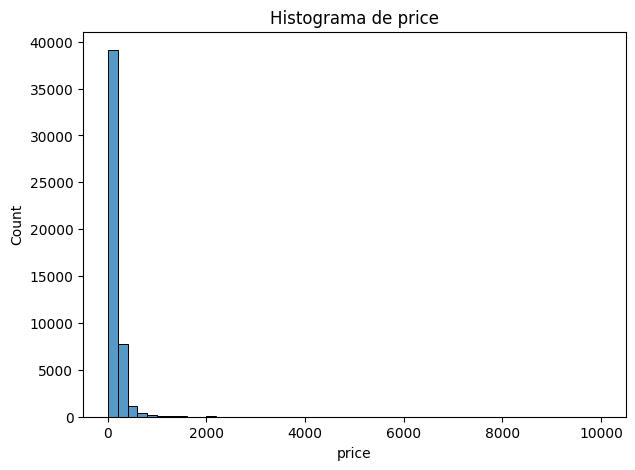

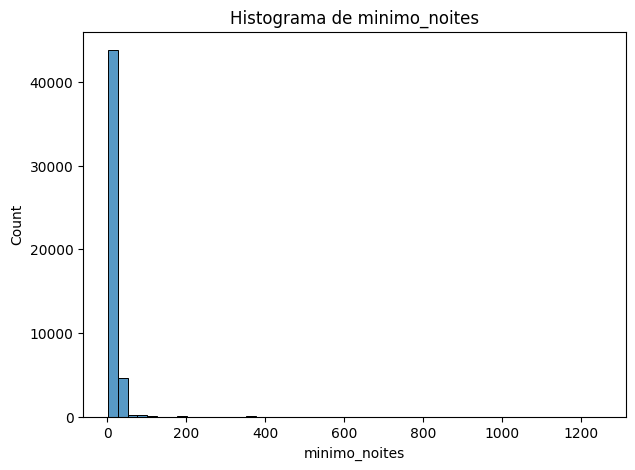

In [10]:
numerical_features = ['price', 'minimo_noites']

# Mostra os histogramas (com outliers) de price

for col in numerical_features:
    plt.figure(figsize=(7,5))
    sns.histplot(df[col], bins=50)
    plt.title(f'Histograma de {col}')
plt.show()


É possível notar que os valores de preço seguem uma distribuição exponencial, então tratarei essa coluna para seguir uma distribuição normal ao aplicar a função log.

E após isso, com os dados simétricos, utilizarei o método Tukey para detectar os outliers que serão removidos.

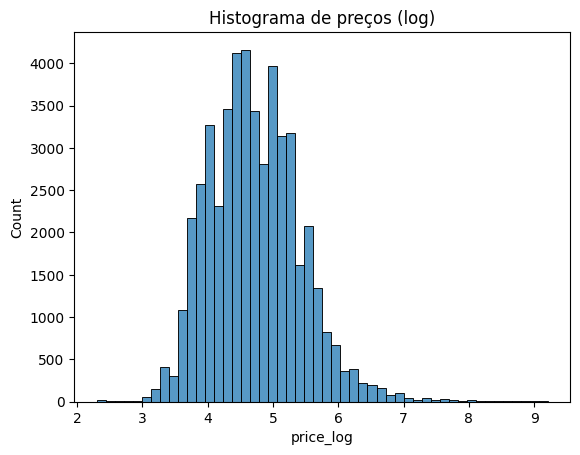

In [11]:
df['price_log'] = np.log(df['price'][df['price'] > 0])

sns.histplot(df['price_log'], bins=50)
plt.title("Histograma de preços (log)")
plt.show()

In [12]:
# Calcula o limite superior de "price_log" usando o método de Tukey
q1 = df["price_log"].quantile(0.25)
q3 = df['price_log'].quantile(0.75)
iqr = q3 - q1
limite_superior_price = q3 + iqr*1.5

# Quantidade de outliers
outliers_price = (df['price_log'] > limite_superior_price).sum()

print(f"Quantidade de amostras com preço maior que o limite superior: {outliers_price}")
print(f"{(outliers_price / df.shape[0]) * 100:.2f}% são outliers")


Quantidade de amostras com preço maior que o limite superior: 589
1.20% são outliers


In [13]:
# Calcula o limite superior de "minimo_noites" usando o percentil 99
limite_superior_noites = df["minimo_noites"].quantile(0.99)

# Quantidade de outliers
outliers_minimo_noites = (df["minimo_noites"] > limite_superior_noites).sum()

print(f"Quantidade de amostras com minimo_noites > {limite_superior_noites}: {outliers_minimo_noites} amostras")
print(f"{(outliers_minimo_noites / df.shape[0]) * 100:.2f}% são outliers")

Quantidade de amostras com minimo_noites > 45.0: 469 amostras
0.96% são outliers


In [14]:
# Remove os outliers de acordo com os criterios acima
df_sem_outlier = df[(df["minimo_noites"] <= limite_superior_noites) & (df["price"] > 0) & (df["price_log"] <= limite_superior_price)]

# Conta quantos outliers foram removidos
amostras_removidas = df.shape[0] - df_sem_outlier.shape[0]
print(f"Foram removidas {amostras_removidas} amostras do dataset, que representam {(amostras_removidas/df.shape[0])*100:.2f}% do total de amostras")

Foram removidas 1046 amostras do dataset, que representam 2.14% do total de amostras


In [15]:
# Finaliza removendo a coluna criada e atribuindo o novo dataframe
df = df_sem_outlier.drop(columns='price_log')
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


Agora que os outliers foram removidos, os histogramas conseguem representar com uma escala melhor a distribuição de valores nas amostras.

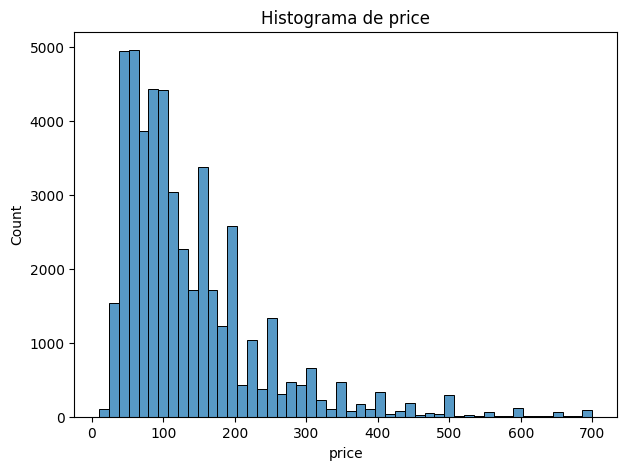

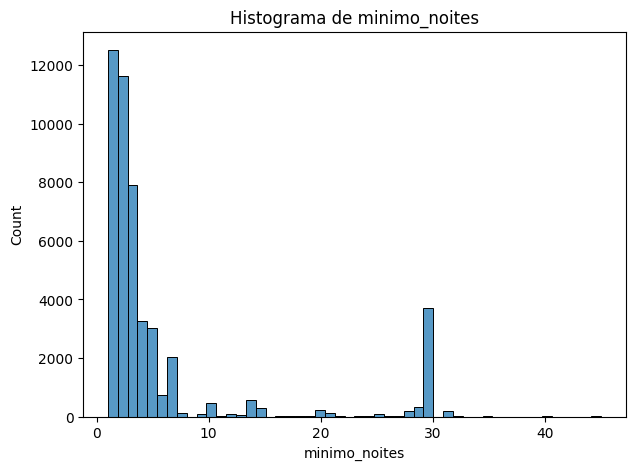

In [16]:
# Mostra os histogramas (sem outliers) de price

for col in numerical_features:
    plt.figure(figsize=(7,5))
    sns.histplot(df[col], bins=50)
    plt.title(f'Histograma de {col}')
plt.show()

## Análise Exploratória dos Dados (EDA)

### Estatísticas Univariadas

#### Variáveis numéricas

In [17]:
numerical_features = ['price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']

In [18]:
df[numerical_features].describe()

,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,47848.000000,47848.000000,47848.000000,38276.000000,47848.000000,47848.000000
mean,136.148115,5.732800,23.581759,1.383156,7.163330,111.222245
std,99.483002,8.442113,44.845863,1.686585,33.135566,130.890783
min,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,105.000000,2.000000,5.000000,0.730000,1.000000,43.000000
75%,175.000000,5.000000,24.000000,2.040000,2.000000,221.250000
max,700.000000,45.000000,629.000000,58.500000,327.000000,365.000000


Ao analisar as informações estatísticas para as variáveis numéricas, é possível perceber que todas possuem a média superior a mediana, indicando que essas variáveis nas amostras estão mais concentradas em valores mais baixos, ou seja, a distribuição possui uma assimetria positiva (right skewed).

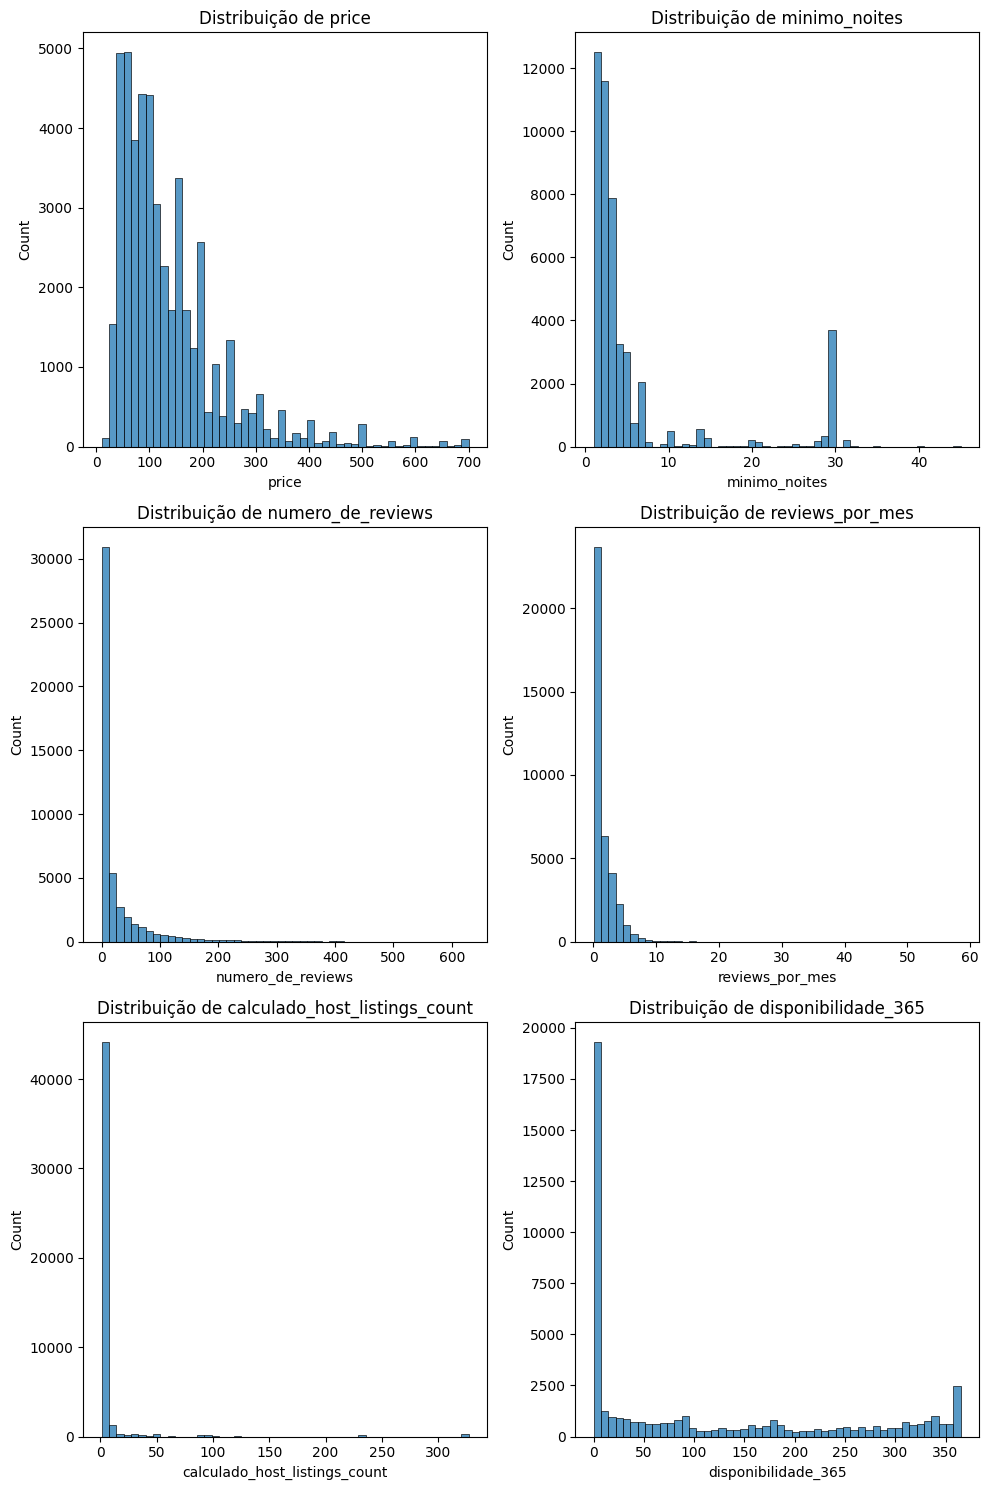

In [19]:
plt.figure(figsize=(10, 15))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 2, i+1)
    sns.histplot(df[col], bins=50)
    plt.title(f'Distribuição de {col}')

plt.tight_layout()
plt.show()

Os histogramas confirmam a hipótese formulada anteriormente sobre a distribuição dos dados.

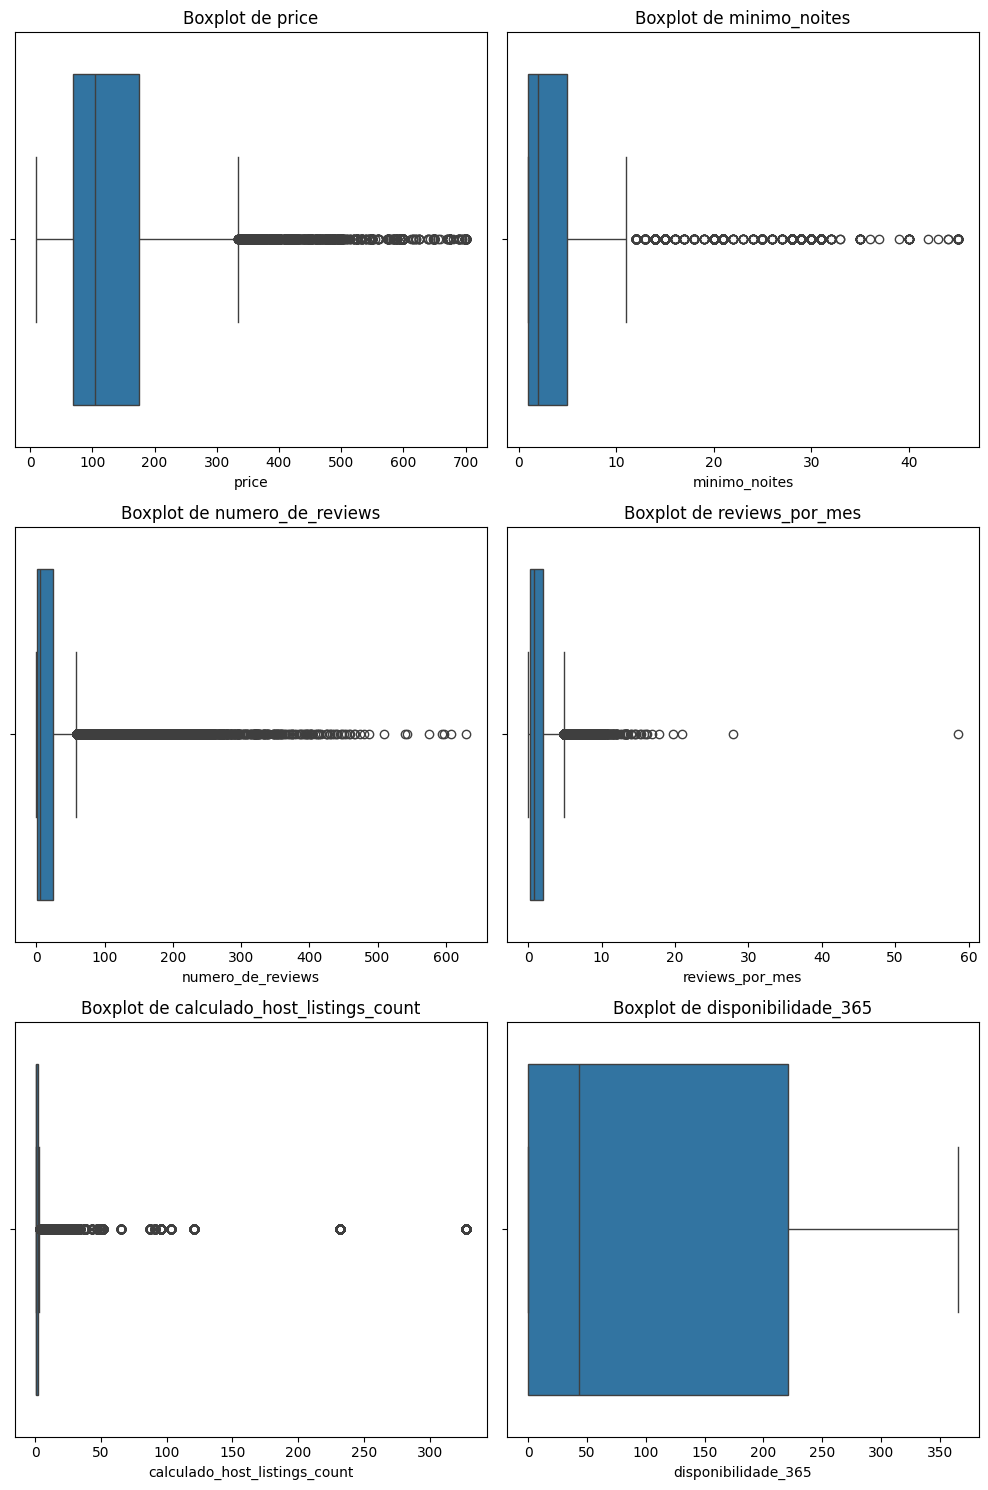

In [20]:
# Mostra os boxplots das variáveis numéricas
plt.figure(figsize=(10, 15))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()

Os boxplots confirmam o mesmo comportamento visto nas análises estatísticas e nos histogramas, apresentando muitos valores acima dos whiskers superiores, o que é comum de acontecer em distribuições que são assimétricas.

#### Variáveis categóricas

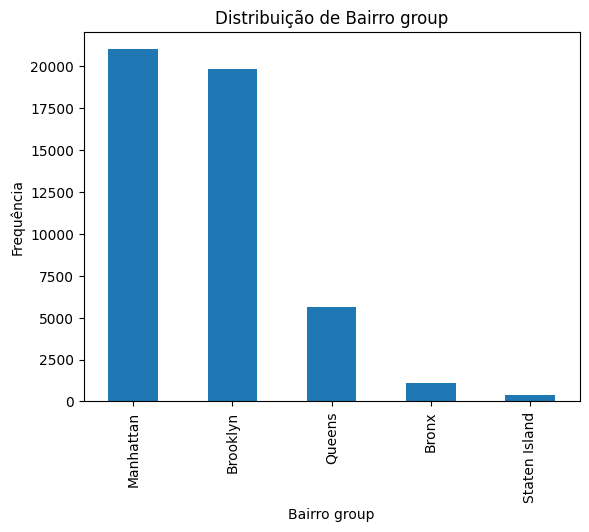

In [21]:
df['bairro_group'].value_counts().plot(kind='bar')
plt.title("Distribuição de Bairro group")
plt.xlabel("Bairro group")
plt.ylabel("Frequência")
plt.show()

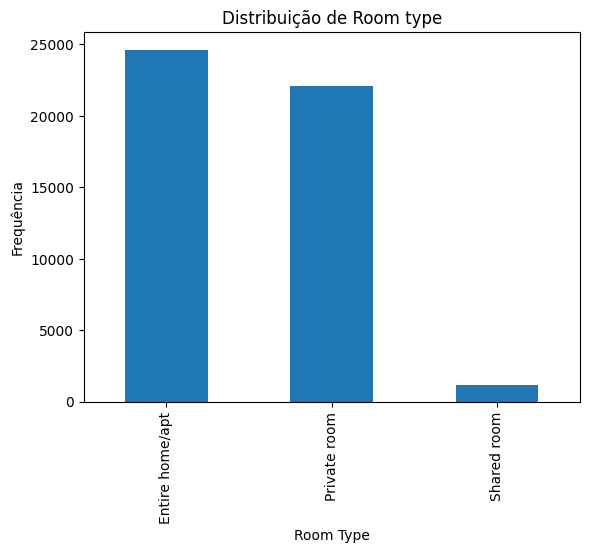

In [22]:
df['room_type'].value_counts().plot(kind='bar')
plt.title("Distribuição de Room type")
plt.xlabel("Room Type")
plt.ylabel("Frequência")
plt.show()

A partir dos gráficos de barras, conseguimos notar algumas tendências interessantes no nosso dataset. A maioria das amostras se encontram nos bairros de Manhattan e Brooklyn. Curiosamente a população de Nova York está mais concentrada nos bairros Brooklyn, Queens e Manhatann, com 30.97%, 27.25% e 19.16% da população, respectivamente _(fonte: NYC OpenData 2020, data.cityofnewyork.us)_, o que pode indicar que o bairro de Queens não é tão atrativo para o mercado de aluguéis temporários, ou talvez exista um possível viés na coleta das amostras.

Outra análise que pode ser feita é que existem poucas amostras do tipo "Shared room", indicando que há uma demanda maior por privacidade e que esse tipo de acomodação não é tão atraente para o público-alvo do mercado de aluguéis temporários.

### Estatísticas Bivariadas

#### Variáveis numéricas x Variáveis numéricas

Para analisar como as variáveis numéricas estão relacionadas, vou calcular a correlação entre elas. Como os dados não seguem uma distribuição gaussiana, vou utilizar o método de Spearman que é mais adequado para esse dataset.

In [23]:
correlation_matrix = df[numerical_features].corr(method='spearman')
correlation_matrix

,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
price,1.000000,0.106554,-0.044744,-0.015600,-0.110092,0.076694
minimo_noites,0.106554,1.000000,-0.172619,-0.286135,0.067219,0.068704
numero_de_reviews,-0.044744,-0.172619,1.000000,0.706808,0.056718,0.248741
reviews_por_mes,-0.015600,-0.286135,0.706808,1.000000,0.148812,0.401294
calculado_host_listings_count,-0.110092,0.067219,0.056718,0.148812,1.000000,0.412946
disponibilidade_365,0.076694,0.068704,0.248741,0.401294,0.412946,1.000000


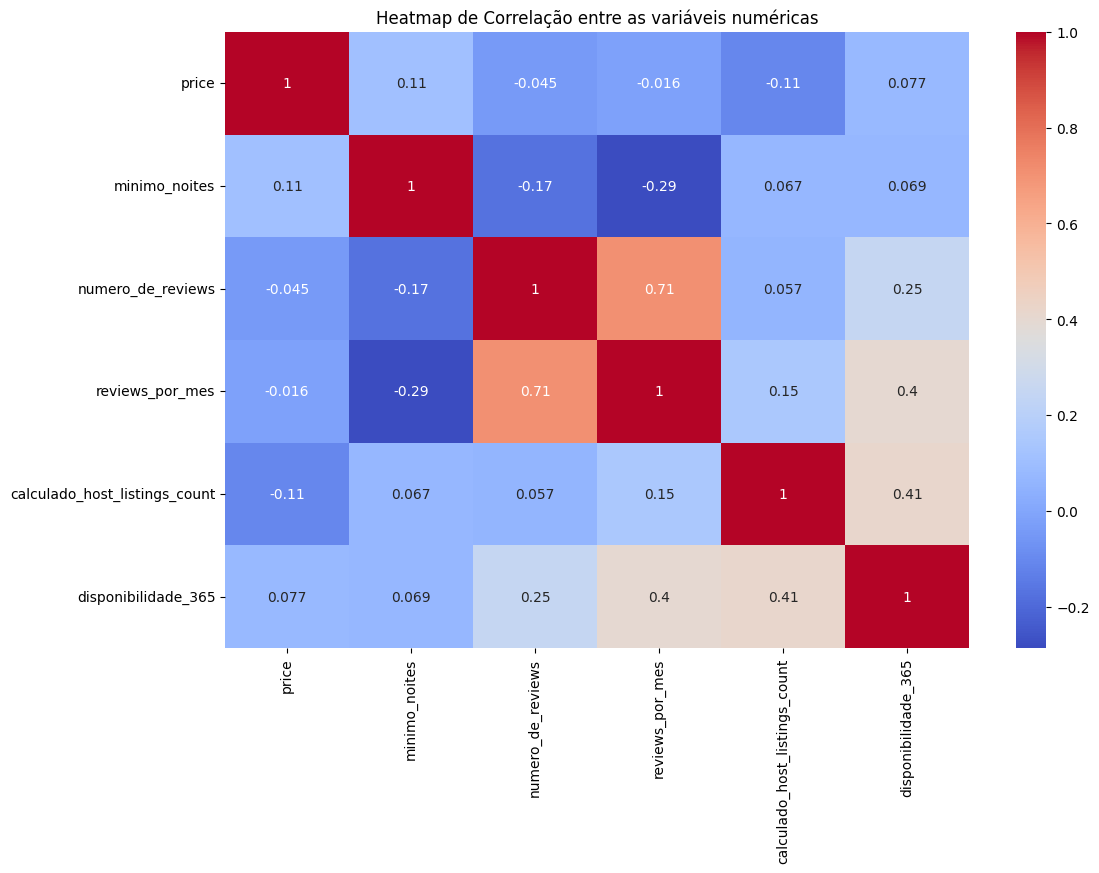

In [24]:
# Plota o heatmap da matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap de Correlação entre as variáveis numéricas')
plt.show()

Grande parte das variáveis não apresentam uma correlação significativa entre si, com exceção de `numero_de_reviews` e `reviews_por_mes`, o que é natural, pois quanto mais reviews por mês a listagem recebe, mais reviews terá no total.

Vale notar também a correlação entre disponibilidade e reviews por mês, por mais que não seja tão alta, indica que listagens que estão disponíveis por mais tempo têm mais chances de serem reservadas com frequência, resultando em mais reviews. E a correlação entre disponibilidade e a quantidade de listagens por host, pois hosts com várias propriedades tratam o aluguel como um negócio profissional, matendo suas listagens disponíveis por mais tempo para maximizar os lucros.

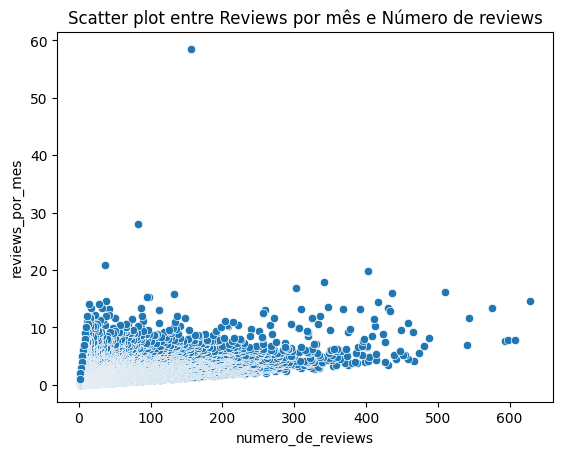

In [25]:
sns.scatterplot(data = df, x='numero_de_reviews', y='reviews_por_mes')
plt.title("Scatter plot entre Reviews por mês e Número de reviews")
plt.show()

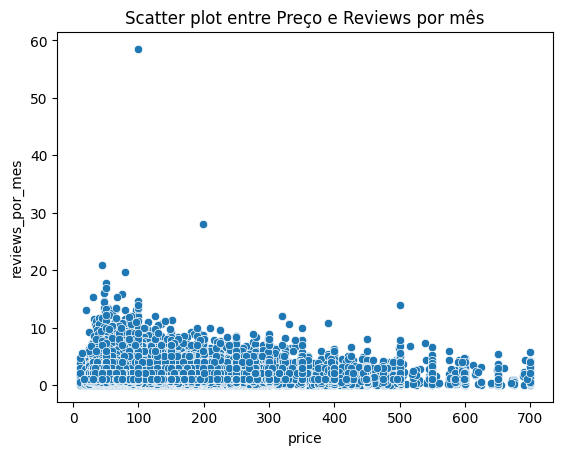

In [26]:
sns.scatterplot(data = df, x='price', y='reviews_por_mes')
plt.title("Scatter plot entre Preço e Reviews por mês")
plt.show()

Ao comparar os gráficos de dispersão, podemos ver claramente no primeiro a correlação positiva entre o número de reviews e a quantidade de reviews que a listagem possui, enquanto que no segundo não existe uma relação direta entre o preço do aluguel e a quantidade média de reviews que recebe no mês. Mas vale ressaltar que nos 2 casos a maioria das amostras se concentram em valores mais baixos, como visto em análises feitas anteriormente.

#### Variáveis categóricas x Variáveis categóricas

In [27]:
tabela_contingencia = pd.crosstab(df['bairro_group'], df['room_type'])

print(tabela_contingencia)

room_type      Entire home/apt  Private room  Shared room
bairro_group                                             
Bronx                      369           648           58
Brooklyn                  9374         10032          409
Manhattan                12644          7857          469
Queens                    2076          3351          193
Staten Island              171           188            9


In [28]:
# Calcula a porcentagem para cada tipo de espaço em relação ao total de cada bairro
percentuais = tabela_contingencia.div(tabela_contingencia.sum(axis=1), axis=0) * 100

# Exibe os percentuais
print(percentuais)

room_type      Entire home/apt  Private room  Shared room
bairro_group                                             
Bronx                34.325581     60.279070     5.395349
Brooklyn             47.307595     50.628312     2.064093
Manhattan            60.295660     37.467811     2.236528
Queens               36.939502     59.626335     3.434164
Staten Island        46.467391     51.086957     2.445652


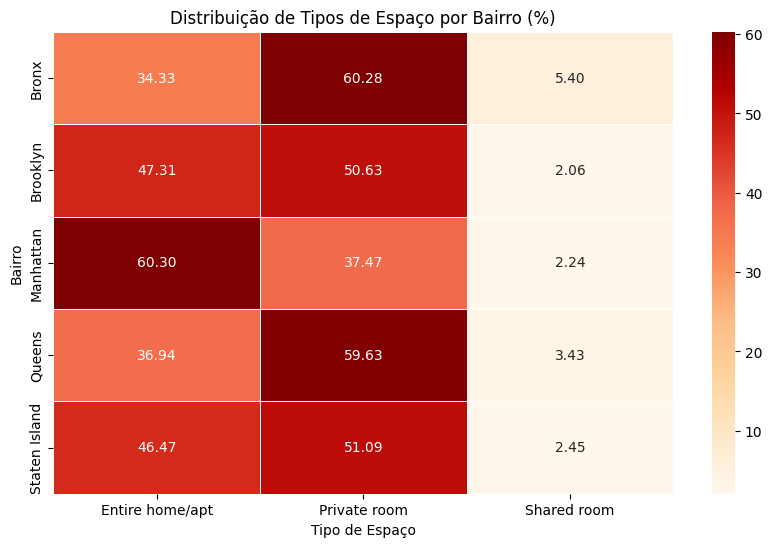

In [29]:
plt.figure(figsize=(10, 6))
sns.heatmap(percentuais, annot=True, fmt='.2f', cmap='OrRd', linewidths=0.5)

plt.title('Distribuição de Tipos de Espaço por Bairro (%)')
plt.xlabel('Tipo de Espaço')
plt.ylabel('Bairro')
plt.show()

É interessante notar que em Manhattan é mais comum o alguel de Entire home/apt, enquanto que nos bairros Bronx e Queens o mais comum é o aluguel de private rooms. Isso pode sugerir que Manhattan possui uma maior demanda por acomodações privadas e independentes, enquanto que a demanda em Bronx e Queens por private room indica que as pessoas procuram por opções mais econômicas, onde os inquilinos estão mais dispostos a dividir o espaço.

#### Variáveis numéricas x Variáveis categóricas

Como o bairro de Manhattan é o centro turístico do estado de Nova York, é possível criar uma hipótese que consequentemente terá preços mais elevados em comparação com os outros bairros. Para verificar isso, vou criar boxplots que relacionem o preço listado com o bairro onde está localizado, e em seguida realizar testes de hipótese para confirmar, considerando o seguinte:
 - Hipótese nula: O preço em Manhattan não é maior que o preço nos outros bairros.
 - Hipótese alternativa: O preço em Manhattan é maior que o preço médio em outros bairros.

O teste usado será o Mann-Whitney U.

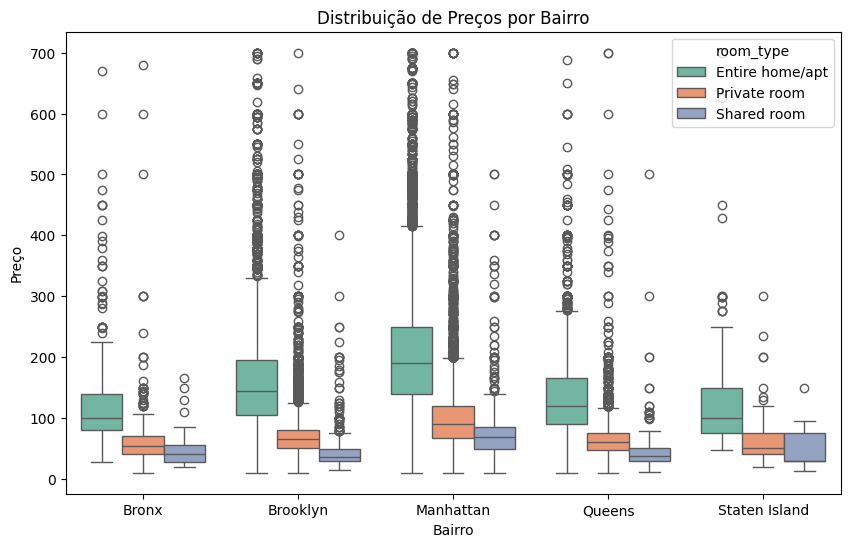

In [30]:
# Plota os boxplots de preços por bairro
plt.figure(figsize=(10, 6))
sns.boxplot(x='bairro_group', y='price', data=df, palette='Set2', hue='room_type')
plt.title('Distribuição de Preços por Bairro')
plt.xlabel('Bairro')
plt.ylabel('Preço')
plt.show()

In [31]:
# Separa os dados de Manhattan e outros bairros
manhattan_prices = df[df['bairro_group'] == 'Manhattan']['price']
other_boroughs_prices = df[df['bairro_group'] != 'Manhattan']['price']

# Realiza o teste
u_stat, p_value = stats.mannwhitneyu(manhattan_prices, other_boroughs_prices, alternative='greater')

# Exibe os resultados
print(f"Estatística U: {u_stat}")
print(f"Valor p: {p_value}")

Estatística U: 399413357.0
Valor p: 0.0


Como o p-value foi igual a 0, a hipótese nula está rejeitada, portanto é possível afirmar que de fato os preços de aluguéis temporários no bairro de Manhattan são maiores que os preços em outros bairros de Nova York.

## Respondendo às perguntas

### 2a)
**Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?**


Para responder essa pergunta, coletei os dados de compras de imóveis no estado de Nova York, a partir do [NYC OpenData](https://data.cityofnewyork.us/City-Government/NYC-Citywide-Annualized-Calendar-Sales-Update/w2pb-icbu) atualizado em 2023.

In [32]:
df_sales = pd.read_csv("../data/NYC_Citywide_Annualized_Calendar_Sales_Update_20250201.csv")
df_sales.head()

C:\Users\Thiago\AppData\Local\Temp\ipykernel_1352\658482836.py:1: DtypeWarning: Columns (0,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sales = pd.read_csv("../data/NYC_Citywide_Annualized_Calendar_Sales_Update_20250201.csv")


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AS OF FINAL ROLL,BLOCK,LOT,EASE-MENT,BUILDING CLASS AS OF FINAL ROLL,ADDRESS,APARTMENT NUMBER,...,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Census Tract 2020,NTA Code
0,1,CHELSEA,21 OFFICE BUILDINGS,4,697,5,NaN,O2,555 WEST 25TH STREET,NaN,...,40.749704,-74.004930,104.0,3.0,99.0,1012379.0,1.006970e+09,Hudson Yards-Chelsea-Flatiron-Union Square,NaN,NaN
1,1,CHELSEA,21 OFFICE BUILDINGS,4,697,23,NaN,O6,511 WEST 25TH STREET,NaN,...,40.749364,-74.004132,104.0,3.0,99.0,1012382.0,1.006970e+09,Hudson Yards-Chelsea-Flatiron-Union Square,NaN,NaN
2,1,CHELSEA,21 OFFICE BUILDINGS,4,700,55,NaN,O2,538 WEST 29TH STREET,NaN,...,40.752067,-74.002931,104.0,3.0,99.0,1012435.0,1.007000e+09,Hudson Yards-Chelsea-Flatiron-Union Square,NaN,NaN
3,1,CHELSEA,21 OFFICE BUILDINGS,4,712,1,NaN,O6,450 WEST 15TH,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CHELSEA,21 OFFICE BUILDINGS,4,746,64,NaN,O8,340 WEST 23RD STREET,NaN,...,40.745809,-73.999729,104.0,3.0,93.0,1013367.0,1.007460e+09,Hudson Yards-Chelsea-Flatiron-Union Square,NaN,NaN


Como o dataset possui muitas amostras e muitas colunas irrelevantes para a análise de preços, utilizarei somente as colunas `BOROUGH` (bairro onde o imóvel está localizado) e `SALE PRICE` (preço de venda do imóvel)

In [33]:
df_sales = df_sales[['BOROUGH', 'SALE PRICE']]

Outro problema do dataset é a falta de consistência na coluna que representa o bairro, para isso irei considerar apenas as amostras que possuem o nome do bairro escrito por extenso, descartando as amostras que usam números para representar os bairros (int ou string). E em seguida removerei os outliers usando novamente o método de Tukey para a detecção, e também removendo as amostras que possuem o preço de venda igual a 0.

In [34]:
print(df_sales['BOROUGH'].value_counts())

BOROUGH
4                107146
3                 97780
1                 75287
QUEENS            51513
BROOKLYN          48864
MANHATTAN         35636
5                 34682
4                 29401
2                 29221
3                 26033
1                 20801
STATEN ISLAND     17424
BRONX             14337
5                  9137
2                  8998
Name: count, dtype: int64


In [35]:
# Remove as amostras que não são strings
df_sales = df_sales[df_sales['BOROUGH'].apply(lambda x: isinstance(x, str))]

# Remove os valores numéricos mesmo que estejam como strings
df_sales = df_sales[~df_sales['BOROUGH'].str.isdigit()]

print(df_sales['BOROUGH'].value_counts())

BOROUGH
QUEENS           51513
BROOKLYN         48864
MANHATTAN        35636
STATEN ISLAND    17424
BRONX            14337
Name: count, dtype: int64


In [36]:
# Calcula o IQR (intervalo interquartil) para 'Sale Price'
Q1 = df_sales['SALE PRICE'].quantile(0.25)
Q3 = df_sales['SALE PRICE'].quantile(0.75)
IQR = Q3 - Q1

# Define o limite superior
limite_superior = Q3 + 1.5 * IQR

# Filtra os dados removendo os outliers
df_sem_outliers = df_sales[(df_sales['SALE PRICE'] > 0) & (df_sales['SALE PRICE'] <= limite_superior)]

# Verifica o número de amostras após a remoção
print(f"Número de amostras após a remoção de outliers: {df_sem_outliers.shape[0]}")

Número de amostras após a remoção de outliers: 104338


In [37]:
df_sales = df_sem_outliers
df_sales.head()

,BOROUGH,SALE PRICE
32922,MANHATTAN,960000
32981,MANHATTAN,575000
33333,MANHATTAN,985000
34542,MANHATTAN,774584
34935,MANHATTAN,843111


<Axes: xlabel='SALE PRICE', ylabel='Count'>

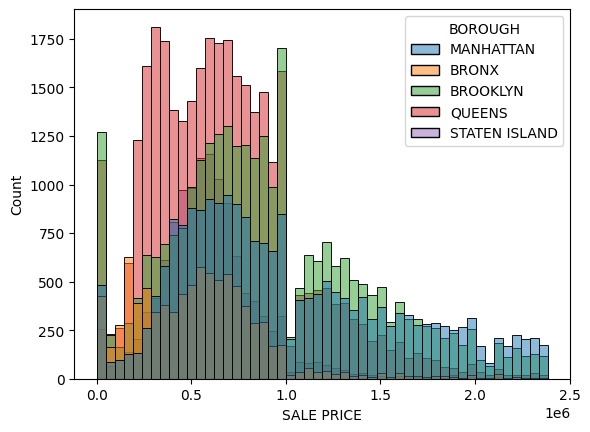

In [38]:
sns.histplot(data=df_sales, x='SALE PRICE', bins=50, hue='BOROUGH')

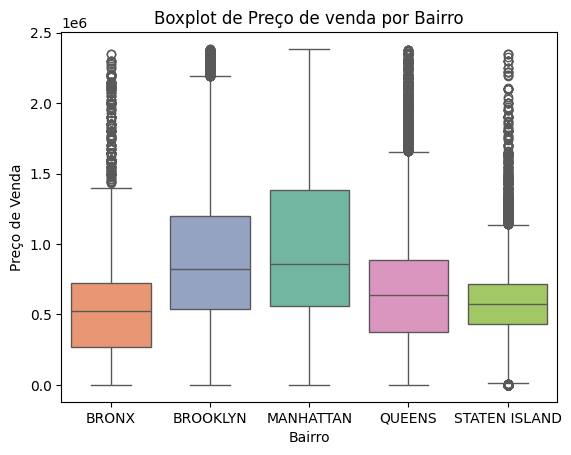

In [39]:
sns.boxplot(x='BOROUGH', y='SALE PRICE', data=df_sales, palette='Set2', hue='BOROUGH', order=sorted(df_sales['BOROUGH'].unique()))
plt.title('Boxplot de Preço de venda por Bairro')
plt.xlabel('Bairro')
plt.ylabel('Preço de Venda')
plt.show()

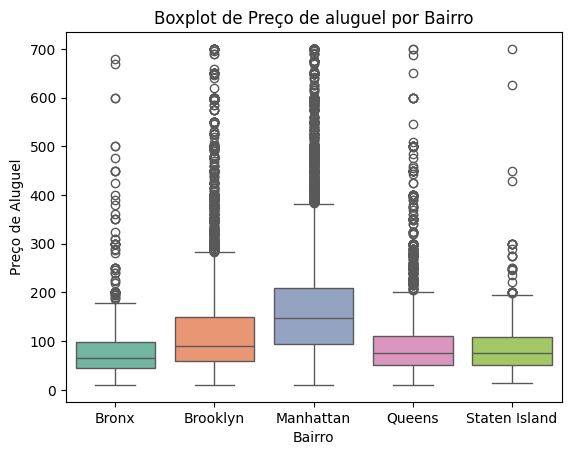

In [40]:
sns.boxplot(x='bairro_group', y='price', data=df, palette='Set2', hue='bairro_group')
plt.title('Boxplot de Preço de aluguel por Bairro')
plt.xlabel('Bairro')
plt.ylabel('Preço de Aluguel')
plt.show()

Ao analisar os gráficos de preço de venda e preço de aluguel por bairro em Nova York, é possível observar uma tendência interessante. Manhattan é o bairro que tem os maiores preços de vendas e também os preços de aluguel mais caros, o que indica a sua alta demanda como o centro financeiro de Nova York. Sugerindo que, para uma pessoa buscando investir em um imóvel para alugar, Manhattan é a opção mais lucrativa, embora possua um preço de aquisição do imóvel mais elevado.

Por outro lado, Bronx apresenta os preços de vendas mais baixos e de aluguel também. Indicando que o bairro é mais acessível para aluguel, atraindo um público que busca opções mais econômicas, mas esses preços mais baixos vão gerar uma margem de lucro menor para quem pretende alugar o imóvel.

### 2b)
**O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?**

In [41]:
# Matriz de correlação entre as variáveis da pergunta
correlacoes = df[['minimo_noites', 'disponibilidade_365', 'price']].corr(method='spearman')
print(correlacoes)

                     minimo_noites  disponibilidade_365     price
minimo_noites             1.000000             0.068704  0.106554
disponibilidade_365       0.068704             1.000000  0.076694
price                     0.106554             0.076694  1.000000


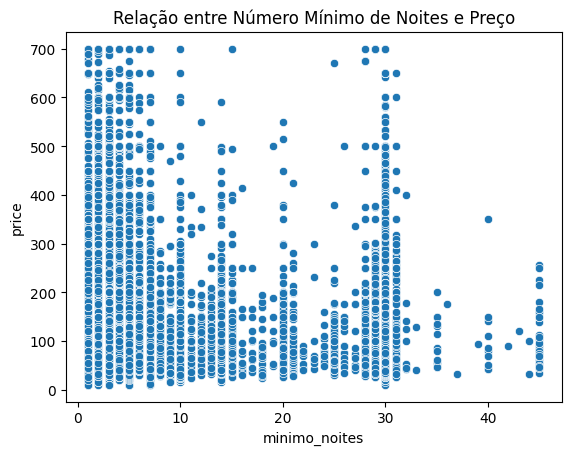

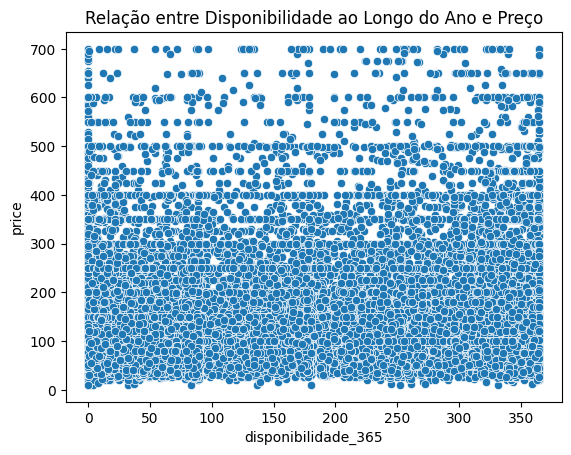

In [42]:
# Plota o gráfico de dispersão entre minimo_noites e price
sns.scatterplot(data=df, x='minimo_noites', y='price')
plt.title('Relação entre Número Mínimo de Noites e Preço')
plt.show()

# Plota o gráfico de dispersão entre disponibilidade_365 e price
sns.scatterplot(data=df, x='disponibilidade_365', y='price')
plt.title('Relação entre Disponibilidade ao Longo do Ano e Preço')
plt.show()

Existe uma correlação muito fraca entre essas 2 variáveis e o preço. No caso do número mínimo de noites a correlação é próxima a 0.1, indicando que o número mínimo de noites não está fortemente relacionando com o preço do aluguel. E na disponibilidade, a correlação é ainda menor, ou seja, tem uma influência quase nula sobre o preço.

### 2c)
**Existe algum padrão no texto do nome do local para lugares de mais alto valor?**

In [43]:
# limpa os nomes dos anúncios (remove pontuação e deixa todas as letras minúsculas)

def limpar_texto(texto):
  texto = texto.lower() # converte para minúsculas
  texto = texto.translate(str.maketrans('', '', string.punctuation)) # remove pontuações
  return texto

df['nome_limpo'] = df['nome'].apply(limpar_texto)

In [44]:
df = df.dropna(subset=['nome'])

In [45]:
# Calcular o 90º percentil do preço de venda
percentil_90 = df['price'].quantile(0.80)

# Filtrar as amostras que estão acima do percentil
df_alto_valor = df[df['price'] > percentil_90]

In [46]:
vectorizer = CountVectorizer(stop_words = 'english') # Exclue palavras comuns no inglês

# Verifica a frequencia de palavras que aparecem no nome dos anúncios de todos os alugueis
X_geral = vectorizer.fit_transform(df['nome_limpo'])
frequencias_geral = pd.DataFrame(X_geral.toarray(), columns=vectorizer.get_feature_names_out())
frequencias_sum_geral = frequencias_geral.sum().sort_values(ascending=False).head(20)

frequencias_sum_geral

room            9945
bedroom         7452
private         7083
apartment       6587
cozy            4972
apt             4537
brooklyn        4001
studio          3939
spacious        3679
manhattan       3376
park            2982
east            2964
sunny           2834
williamsburg    2606
beautiful       2433
near            2281
village         2183
nyc             2113
heart           2029
large           2005
dtype: int64

In [47]:
# Verifica a frequencia de palavras que aparecem no nome dos anúncios dos alugueis mais caros
X_caros = vectorizer.fit_transform(df_alto_valor['nome_limpo'])
frequencias_caros = pd.DataFrame(X_caros.toarray(), columns=vectorizer.get_feature_names_out())
frequencias_sum_caros = frequencias_caros.sum().sort_values(ascending=False).head(20)

frequencias_sum_caros

apartment       1390
bedroom         1375
apt             1113
village          800
luxury           729
east             716
studio           703
spacious         688
loft             683
park             679
manhattan        624
1br              619
west             592
williamsburg     540
nyc              488
central          486
brooklyn         483
heart            483
private          481
midtown          481
dtype: int64

In [48]:
# Verifica as palavras mais frequentes que aparecem somente em alugueis mais caros
palavras_caros_unicas = frequencias_sum_caros[~frequencias_sum_caros.index.isin(frequencias_sum_geral.index)]
print(palavras_caros_unicas)

luxury     729
loft       683
1br        619
west       592
central    486
midtown    481
dtype: int64


Iniciei o tratamento dos nomes dos imóveis padronizando o texto para letras minúsculas e removendo pontuações. E para analisar os aluguéis mais caros, selecionei apenas os anúncios com o preço acima do 90º percentil.

Ao comparar as 20 palavras mais frequentes em todos os anúncios com as 20 palavras mais frequentes apenas nos anúncios de alto valor, pude perceber que algumas palavras são mais comuns nos anúncios de preço elevado.

Palavras como "luxury" e "loft" sugerem um estilo de moradia mais sofisticado, enquanto "1br" é usado para sinalizar que possui 1 quarto (bedroom). E por fim as palavras "west", "central" e "midtown" são referentes a localizações em Nova York, especificamente em Manhattan, que, como visto em análises anteriores, é de fato o bairro mais caro de Nova York.

### 3)
**Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?**


In [49]:
# Descarta colunas não relevantes para a previsão
columns_to_drop = ['id', 'host_id', 'host_name', 'nome', 'ultima_review', 'nome_limpo']
df_previsao = df.drop(columns=columns_to_drop)
df_previsao = df_previsao.dropna()

In [50]:
# Separa features e target
X = df_previsao.drop(columns=["price"])
y = df_previsao["price"]

In [51]:
# Faz o one-hot encoding das variáveis categóricas
categorical_features = ['bairro_group', 'room_type', 'bairro']
X = pd.get_dummies(X, columns=categorical_features)

In [52]:
# Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
# Normaliza os dados numéricos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(max_depth=5),
    "Gradient Boost": GradientBoostingRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('='*50)
    print (name)
    print(f"MAE = {mae:.2f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"R2 Score = {r2}")

Linear Regression
MAE = 45.47
RMSE = 71.62
R2 Score = 0.4304496929797883
Ridge
MAE = 45.47
RMSE = 71.62
R2 Score = 0.430452054044843
Lasso
MAE = 45.30
RMSE = 71.55
R2 Score = 0.4316594458022933
Decision Tree
MAE = 44.54
RMSE = 71.25
R2 Score = 0.43643612891728634
Gradient Boost
MAE = 42.57
RMSE = 68.47
R2 Score = 0.47953585827955947
Random Forest
MAE = 41.44
RMSE = 66.42
R2 Score = 0.5101522047509253


In [55]:
# Definindo o modelo RandomForest
rf_model = RandomForestRegressor()

# Definindo os parâmetros a serem otimizados
param_grid = {
    'n_estimators': [50, 100],      # número de árvores na floresta
    'max_depth': [None, 10, 20],    # profundidade máxima das árvores
    'min_samples_split': [2, 5],    # número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2],     # número mínimo de amostras necessárias para ser uma folha
}

# Criando o GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

# Treinando o modelo com GridSearch
grid_search.fit(X_train, y_train)

# Visualizando os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Avaliando o modelo com os melhores parâmetros
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Calculando as métricas de desempenho
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Melhores parâmetros: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
MAE: 40.93877787870776
RMSE: 65.72475599899515
R² Score: 0.5204149233215329


In [56]:
# Criar o modelo com os melhores hiperparâmetros
rf_best = RandomForestRegressor(
    max_depth=20,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_best.fit(X_train, y_train)

# Fazer previsões
y_pred = rf_best.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 40.96
RMSE: 65.81
R² Score: 0.52


Estamos resolvendo um problema de regressão, pois queremos encontrar uma variável contínua (o preço do aluguel), com base nas outras variáveis do dataset.

Para prever o preço do aluguel, descartei algumas variáveis que não traziam informações relevantes para a previsão, como `id`, `host_id`, `host_name`, `nome` e `ultima_review`. Das variáveis categóricas `room_type`, `bairro_group` e `bairro` apliquei uma técnica de one-hot encoding para transformar essa variáveis em colunas binárias, facilitando o uso delas no modelo de regressão. E as variáveis numéricas foram padronizadas usando o Standard Scaler para garantir que todas elas estivessem na mesma escala, evitando que uma variável com uma amplitude maior tivesse uma maior influência no modelo.

Inicialmente testei alguns modelos como Regressão Linear, Árvores de Decisão, Gradient Boost, Ridge e Lasso. Porém, optei por usar o Random Forest pois ele apresentou uma maior velocidade de execução junto com um desempenho bom ao analisar os resultados do MAE, RMSE e R².

Para otimizar ainda mais o desempenho do modelo, usei o GridSearchCV, que realiza uma busca sobre uma grade de parâmetros, selecionando os que apresentam um melhor desempenho com base nas métricas definidas.

As métricas usadas para avaliar o modelo foram:
 - **MAE (Mean Absolute Error)** - Para entender a magnitude do erro com valores absolutos.
 - **RMSE (Root Mean Squared Error)** - Para analisar grandes diferenças entre as previsões e os valores reais.
 - **R² (Coeficiente de determinação)** - Para ver a eficácia do modelo em capturar a variação do preço.

 Embora o Random Forest não tenha atingido o melhor desempenho possível analisando as métricas, ainda sim ele forneceu um bom equilíbrio entre velocidade de execução e precisão.

### 4)

**Supondo um apartamento com as seguintes características:**

```
{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}
```
Qual seria a sua sugestão de preço?

In [57]:
# Define o dicionário de características do apartamento
apartamento = {
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
    }

# Converte o dicionário em um DataFrame
df_apartamento = pd.DataFrame([apartamento])

# Aplica One-Hot Encoding
df_apartamento_encoded = pd.get_dummies(df_apartamento, columns=['bairro_group', 'room_type', 'bairro'])

# Garante que as colunas sejam as mesmas do modelo treinado
colunas_finais = X_train.columns
df_apartamento_encoded = df_apartamento_encoded.reindex(columns=colunas_finais, fill_value=False)

# Faz a previsão do preço usando o modelo treinado
preco_previsto = rf_best.predict(df_apartamento_encoded)

# Exibe o preço previsto
print(f'O preço previsto para o apartamento é: ${preco_previsto[0]:.2f}')


O preço previsto para o apartamento é: $303.89


Para esse apartamento dado no desafio, a sugestão de preço seria $303.89 ao usar o método de Random Forest para regressão.

## Salvando o modelo no formato .pkl

In [58]:
# Salvar o modelo treinado
nome = "random_forest_model.pkl"
joblib.dump(rf_best, f"../model/{nome}")
print(f"Modelo salvo como {nome}")

Modelo salvo como random_forest_model.pkl
